In [2]:
!pip install autodistill

  Obtaining dependency information for autodistill from https://files.pythonhosted.org/packages/6e/23/7abd52eed5c3ef76c89e71107cb9a5d7a1d974b71950851f4f32d5429e18/autodistill-0.1.6-py3-none-any.whl.metadata


In [3]:
from autodistill_seggpt.seggpt import FewShotOntology,SegGPT

import supervision as sv

climbing_dataset = sv.DetectionDataset.from_coco(
    images_directory_path="datasets/Climbing-5/train",
    annotations_path="datasets/Climbing-5/train/_annotations.coco.json",
)

# as tuples
ontology = [
    (("2-floor",[
        "AF1QipPBzeDDJrkRNarWKXj14aPvvfBagdQp2zrTrEmr-s773-k-no_jpeg.rf.82ee9609eafae21d00962e5a8a20c20f.jpg",
        "AF1QipPPoiOGV-KFbtwhkGve4WZLVFstDdx2Z53q-lOB-s1024_jpeg.rf.f124a75329d8f3061f7091cdba77f29b.jpg"
        ]), "floor"),
    (("1-climbing-holds",[
        "1_png.rf.8699b0f8ae17c02c678c2732a96667d7.jpg",
        "AF1QipMWEnam7zGb-HsVjoiH1ei4-z2aXbTf2uqHw1na-s812-k-no_jpeg.rf.4c832adeb2b0f76811d1310e20c0c2b8.jpg",
        ]), "climbing-holds"),
    (("3-person",[
        "AF1QipOVoWEyyfXcSwTOVWvoV4gqyQBtvVRMpHYJua3D-w406-h721-k-no_jpeg.rf.8ee53a6bc6691fb89e2c10860cf1614e.jpg",
        "AF1QipMn-QQ3psltJ93s2gssa85h1T2ROAacjc55e8xw-s1536_jpeg.rf.f1d9d9bb0c0f250270652600108f2d03.jpg"
        ]), "person"),
]

ontology = FewShotOntology(
    ref_dataset=climbing_dataset,
    ontology=ontology
)

model = SegGPT(
    ontology=ontology,
)

demo_img = "datasets/Climbing-5/valid/AF1QipMDOYxdwCQFqetD8LHQyuvybRyg_WfdB8IyR82v-w406-h721-k-no_jpeg.rf.7a66defeb0285c387faf7baf60d3a600.jpg"
detections = model.predict(demo_img)


Model loaded.


In [5]:
print(detections)

Detections(xyxy=array([], shape=(0, 4), dtype=float32), mask=None, confidence=array([], dtype=float32), class_id=array([], dtype=int64), tracker_id=None)


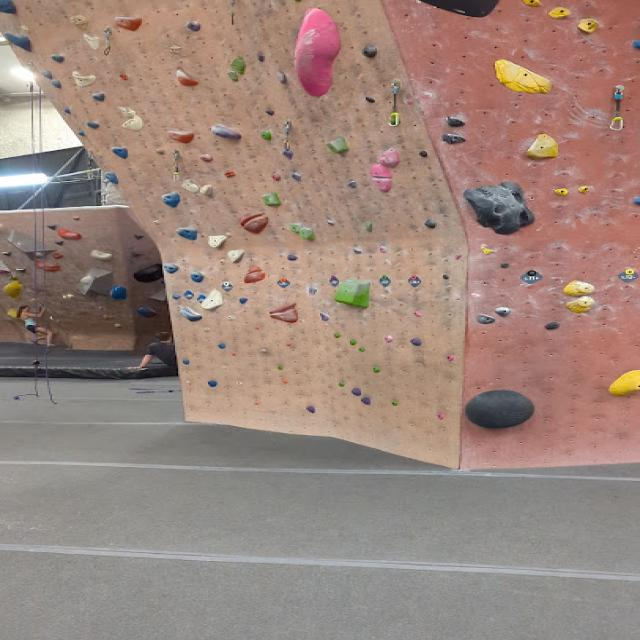

In [4]:
import cv2
from PIL import Image

annotator = sv.MaskAnnotator()
img = cv2.imread(demo_img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

annotated_frame = annotator.annotate(
    scene=img.copy(),
    detections=detections
)
Image.fromarray(annotated_frame)